## Alternating Least Squares for Implicit Feedback Datasets

<hr>

Recommender systems rely on different types of input. Most convenient is the high quality explicit feedback, which includes explicit input by users regarding their interest in products.

For example, Netflix collects star ratings for movies

However, explicit feedback is not always available. Thus, recommenders can infer user preferences from the more abundant implicit feedback, which indirectly reflect opinion through observing user behavior 

<div class="alert alert-success"> <b>Types of implicit feedback in ecommerce include purchase history, browsing history, and add-to-cart history</b> </div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import cv2

from recsys_helper import AlternatingLeastSquares, you_may_also_like

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
%%time

# https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
transactions_df = pd.read_parquet('./transactions.parquet')
customers_df = pd.read_csv('customers.csv', usecols=['customer_id'])
article_df = pd.read_csv('articles.csv', dtype = {'article_id': str})

CPU times: total: 13.2 s
Wall time: 10.6 s


In [3]:
# Assigning incremental ids to customers and articles
all_customers = customers_df['customer_id'].unique().tolist()
all_articles = article_df['article_id'].unique().tolist()

customer_ids = dict(list(enumerate(all_customers)))
article_ids = dict(list(enumerate(all_articles)))

transactions_df['customer_id'] = transactions_df['customer_id'].map({u: uidx for uidx, u in customer_ids.items()})
transactions_df['article_id'] = transactions_df['article_id'].map({i: iidx for iidx, i in article_ids.items()})

# del customers, articles
# gc.collect()

## Data Cleaning

In [4]:
## exclude items purchased by customers more than 20x
df_for_rec = transactions_df.groupby(['customer_id', 'article_id']).size().reset_index(name='total_item')
df_for_rec = df_for_rec[df_for_rec['total_item'] < 20]

## include only customer who bought more than 2 items, and less than 150 items
all_transaction_per_member_df = df_for_rec.groupby('customer_id')['article_id'].apply(list)
all_transaction_per_member_df = all_transaction_per_member_df.reset_index()
all_transaction_per_member_df = all_transaction_per_member_df[(all_transaction_per_member_df['article_id'].str.len() > 2) & (all_transaction_per_member_df['article_id'].str.len() < 150)]

df_for_rec = df_for_rec[df_for_rec['customer_id'].isin(all_transaction_per_member_df.customer_id)]

# save it to parquet
df_for_rec.to_parquet('df_for_rec.parquet')

In [5]:
# df_for_rec = pd.read_parquet('df_for_rec.parquet')

In [23]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Confidence

<img src="https://miro.medium.com/max/410/1*fcx5Y2fkeQeCpghrDvJZFw.png" alt="confidence" width="300" align="left">

r is the interaction between User u and Item i.

More the interaction, more the confidence — scaled on the value α.

A item bought 5 will have more confidence than the item bought just twice. 

In [7]:
# alpha reflects how much we value observed events versus unobserved events. 
# in the paper they found α = 40 to work well

model = AlternatingLeastSquares(df_for_rec,
                                factors=100,
                                regularization=0.15,
                                alpha = 40,
                                iterations=3)

## You May Also Like

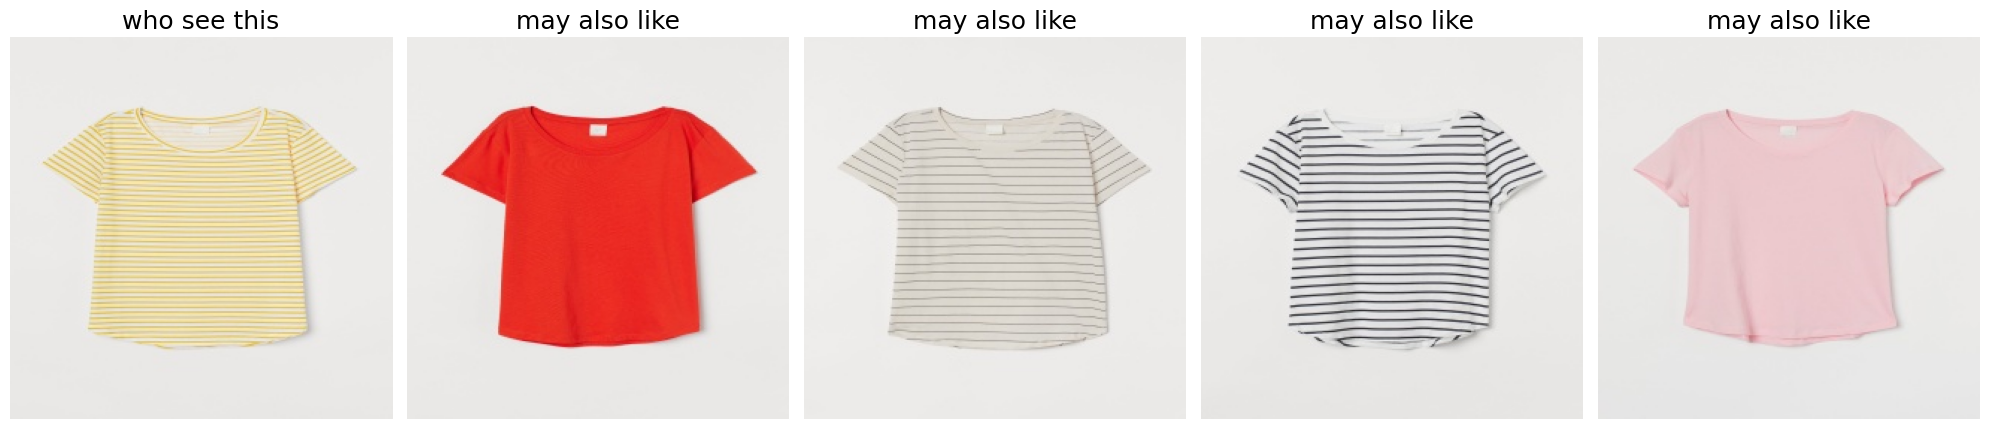

In [8]:
you_may_also_like(24869, model, article_ids)

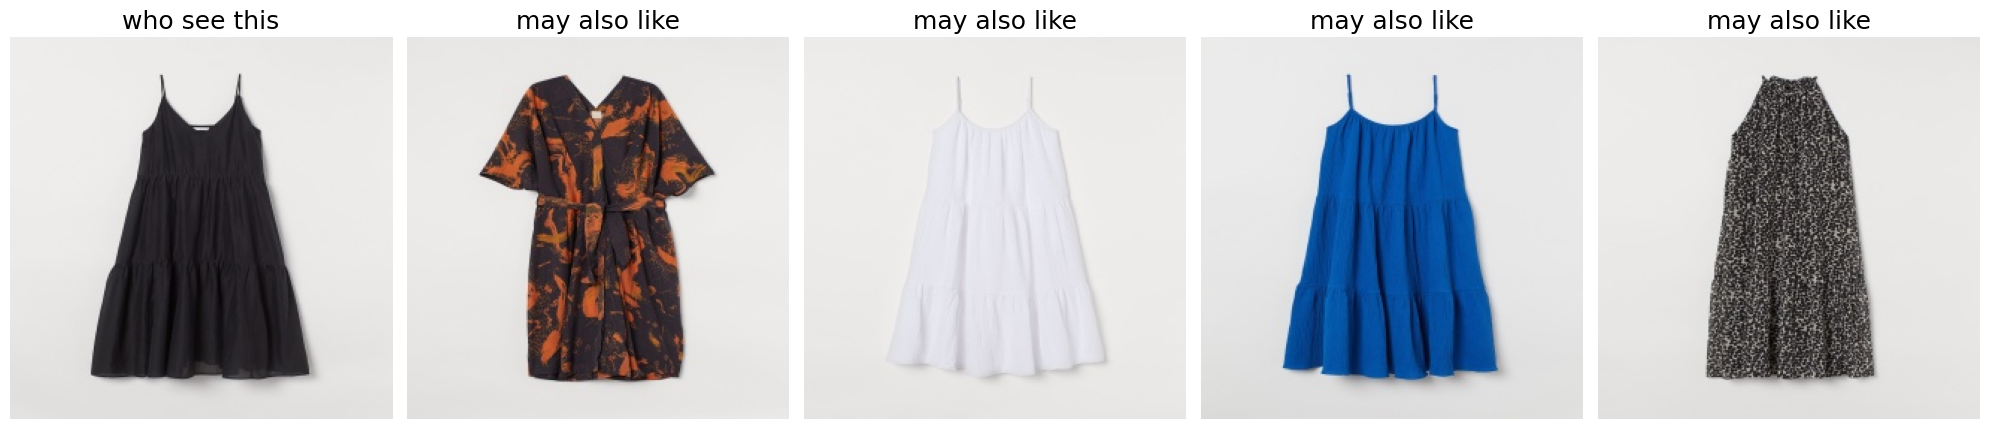

In [9]:
you_may_also_like(98366, model, article_ids)

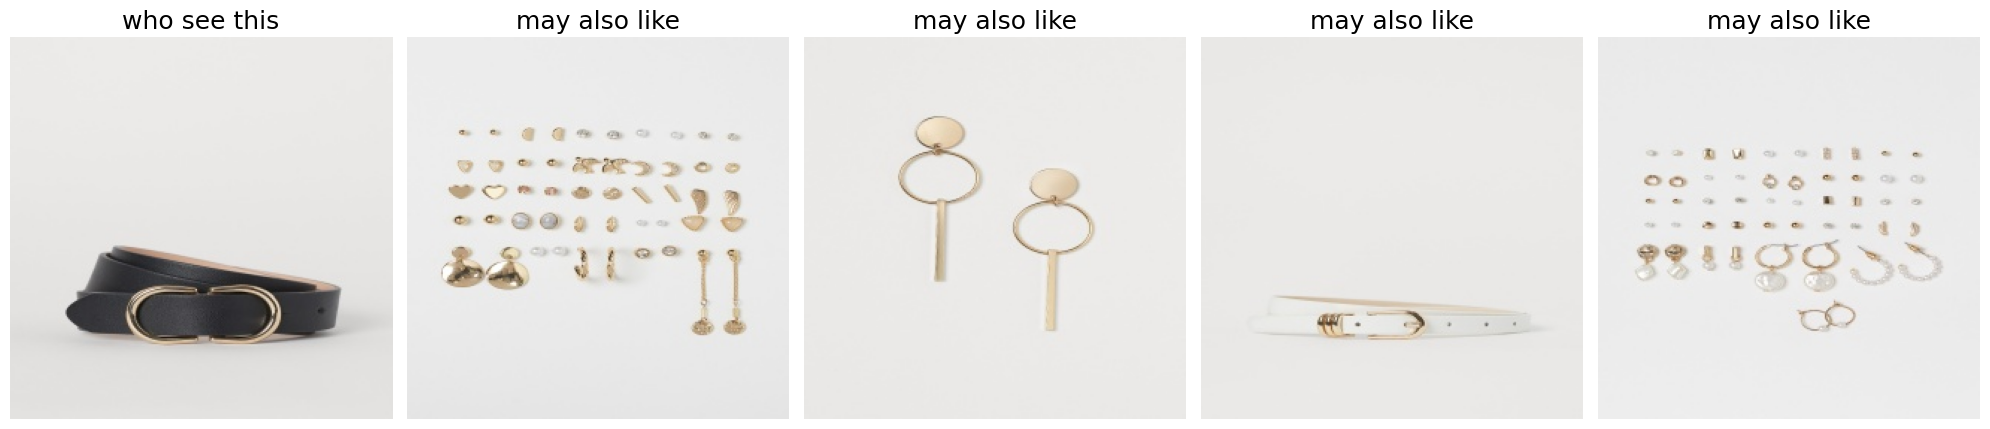

In [10]:
you_may_also_like(74152, model, article_ids)

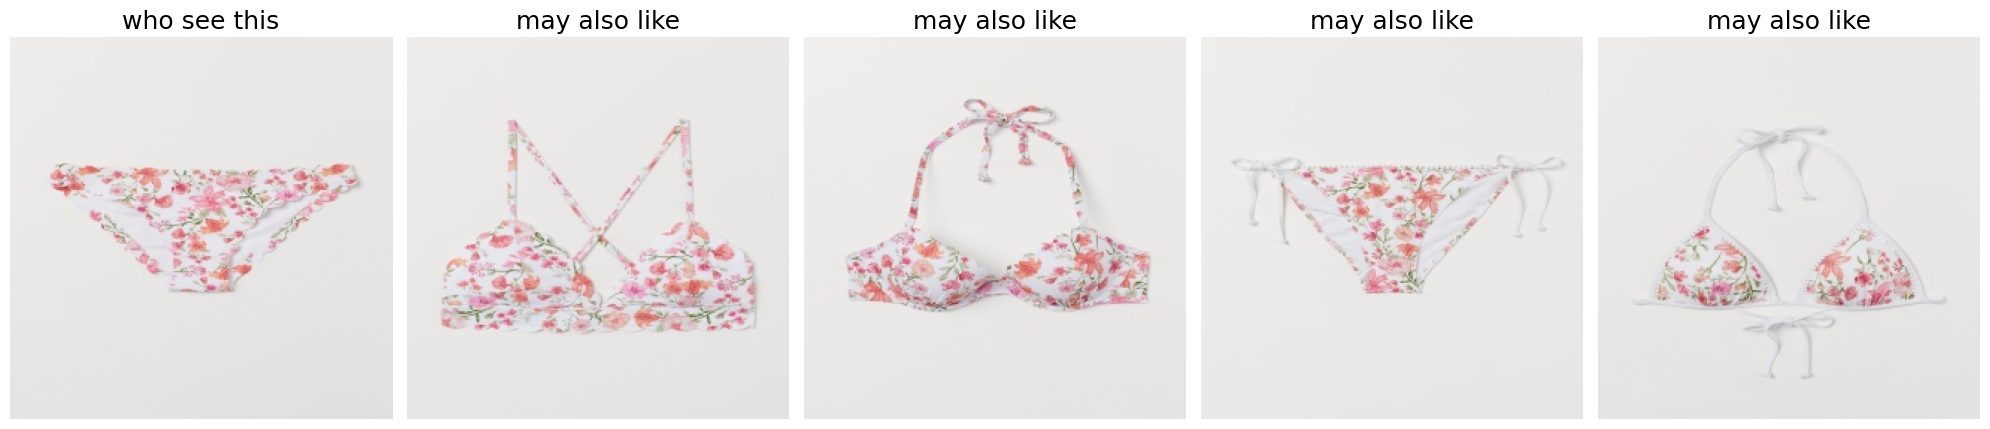

In [11]:
you_may_also_like(1478, model, article_ids)

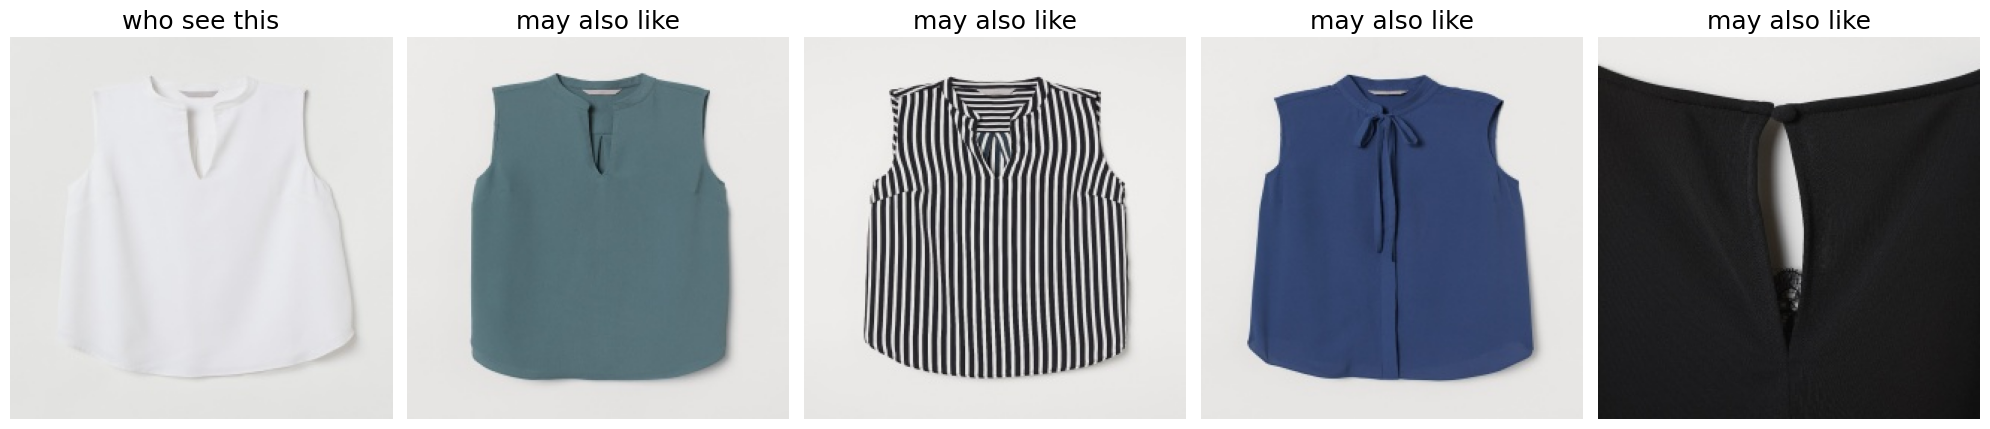

In [12]:
you_may_also_like(23994, model, article_ids)

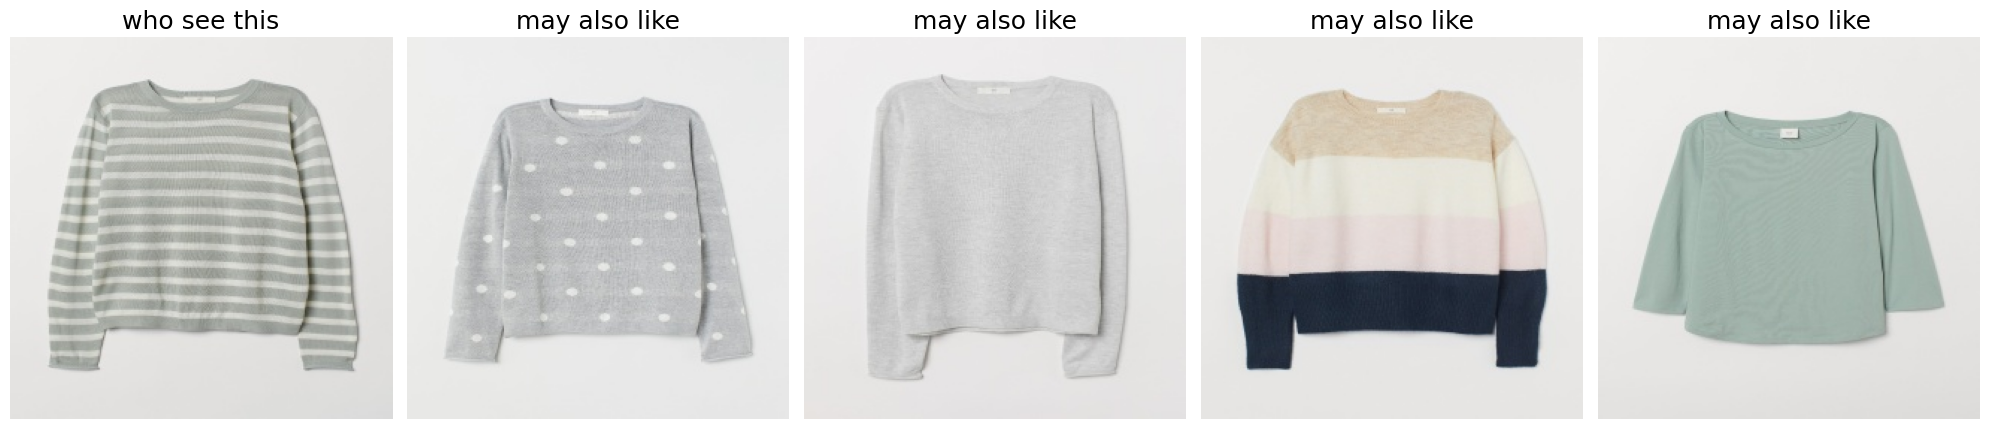

In [13]:
you_may_also_like(48399, model, article_ids)

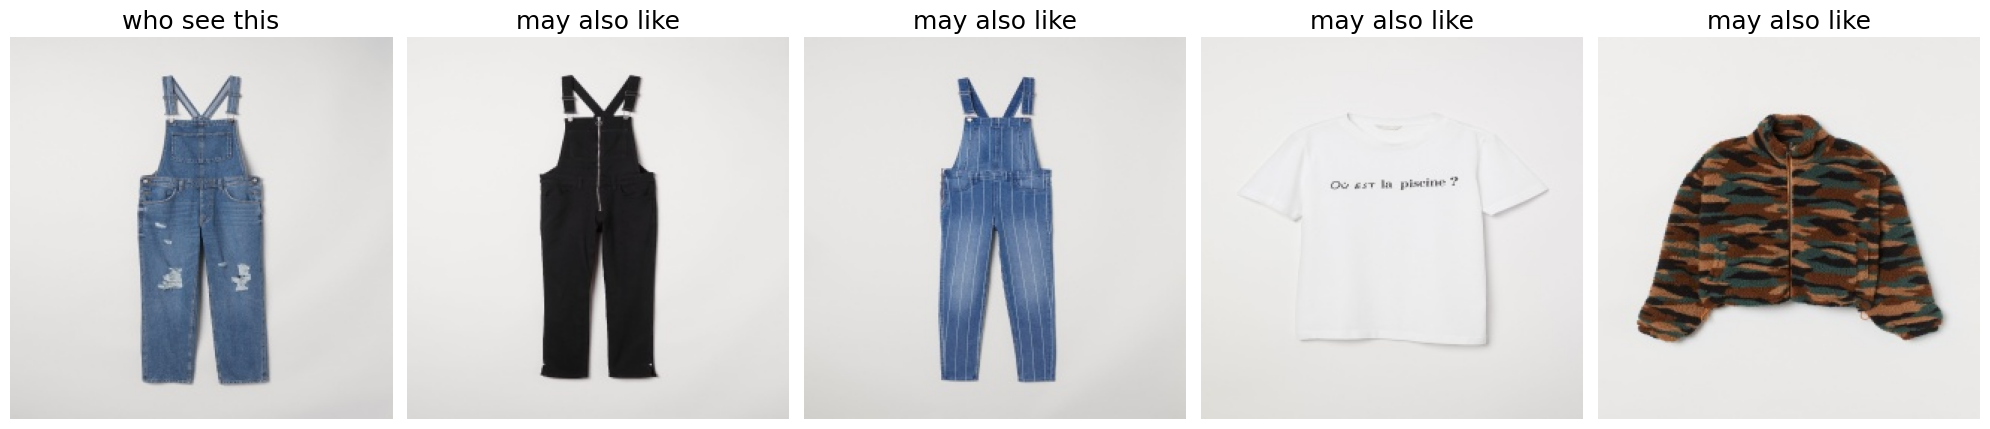

In [14]:
you_may_also_like(2741, model, article_ids)

In [ ]:
## --------------------------------------------------------------------------------------------------------------------- ##

It is crucial to identify the unique characteristics of implicit feedback, which prevent the direct use of algorithms that were designed with explicit feedback in mind.

In the following we list the prime characteristics:

## No negative feedback

<hr>

By observing the users behavior, we can infer which items they probably like and thus chose to consume.

However, it is hard to reliably infer which items a user did not like.

For example, a user that did not buy a certain product maybe because she dislikes the product or just because she did not know about the product yet

<div class="alert alert-success"> <b>This fundamental asymmetry does not exist in explicit feedback where users tell us both what they like and what they dislike.</b> </div>

## Implicit feedback is inherently noisy

<hr>

While we passively track the users behavior, we can only guess their preferences and true motives.

For example, we may view purchase behavior for an individual, but this does not necessarily indicate a positive view of the product.

<div class="alert alert-success"> <b>The item may have been purchased as a gift, or perhaps the user was disappointed with the product</b> </div>

### The numerical value of explicit feedback indicates preference, whereas the numerical value of implicit feedback indicates confidence.

Systems based on explicit feedback let the user express their level of preference, e.g. a star rating between 1 (“totally dislike”) and 5 (“really like”).

On the other hand, numerical values of implicit feedback describe the frequency of actions,

e.g., how much time the user watched a certain show, how frequently a user is buying a certain item, etc.

<div class="alert alert-success"> <b>A larger value is not indicating a higher preference.</b> </div>

In [ ]:
##################################################################################################################
##########################################  To Be Continued  #####################################################
##################################################################################################################

## References:

<hr>

- [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf)